In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

**Import Data**

In [2]:
#import data (March'18-May'18) from MTA turnstile data (http://web.mta.info/developers/turnstile.html)
SEARCH_TYPE = 'Spring'     # 'None' to suppress this cell
if SEARCH_TYPE=='Spring':  # SMB: files sometimes don't load, so added try: below
    TURNSTILE_PATH = 'http://web.mta.info/developers/data/nyct/turnstile/'
    TURNSTILE_FILES = ['turnstile_180310','turnstile_180317','turnstile_180324','turnstile_180331',
                      'turnstile_180407','turnstile_180414','turnstile_180421','turnstile_180428',
                      'turnstile_180505','turnstile_180512','turnstile_180519','turnstile_180526',
                       'turnstile_180602','turnstile_180609']
    turnstile_files = [TURNSTILE_PATH + x + '.txt' for x in TURNSTILE_FILES]

    tflist = []
    for tf in turnstile_files:
        print(f'Opening file {tf[-20:]}')
        try:
            df = pd.read_csv(tf, index_col=None, header=0)
            tflist.append(df)
        except:
            print(f'  Trouble accessing file -> skipping.')
    data_nyc_turnstile = pd.concat(tflist)
    
    #Clean dataframe to include only columns to be used in analysis
    data_nyc_turnstile.columns = data_nyc_turnstile.columns.str.replace(' ', '')

else:
    print('MTA data not loaded; "data_nyc_turnstiles" was not refreshed.')

Opening file turnstile_180310.txt
Opening file turnstile_180317.txt
Opening file turnstile_180324.txt
Opening file turnstile_180331.txt
Opening file turnstile_180407.txt
Opening file turnstile_180414.txt
Opening file turnstile_180421.txt
Opening file turnstile_180428.txt
Opening file turnstile_180505.txt
Opening file turnstile_180512.txt
Opening file turnstile_180519.txt
Opening file turnstile_180526.txt
Opening file turnstile_180602.txt
Opening file turnstile_180609.txt


In [3]:
data_nyc_turnstile.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,03:00:00,REGULAR,6535802,2213345
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,07:00:00,REGULAR,6535813,2213356
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,11:00:00,REGULAR,6535865,2213436


**Data processing**

In [4]:
#Including column['Date_time'] for computing date-time series
data_nyc_turnstile['Date_time'] = data_nyc_turnstile['DATE'] + ' ' + data_nyc_turnstile['TIME']

#Converting ['Date_time'] to datetime64 series
data_nyc_turnstile['Datetime'] = pd.to_datetime(data_nyc_turnstile['Date_time'], format="%m/%d/%Y %H:%M:%S")
data_nyc_turnstile.drop('Date_time', axis=1, inplace=True)

#Adding ['Day of the week' in form of an integer]
data_nyc_turnstile['Day'] = data_nyc_turnstile['Datetime'].dt.dayofweek

data_nyc_turnstile.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Day
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,03:00:00,REGULAR,6535802,2213345,2018-03-03 03:00:00,5
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,07:00:00,REGULAR,6535813,2213356,2018-03-03 07:00:00,5
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/03/2018,11:00:00,REGULAR,6535865,2213436,2018-03-03 11:00:00,5


In [5]:
#Sorting data to calculate traffic for individual turnstile

data_nyc_turnstile.sort_values(by=['STATION', 'UNIT', 'C/A', 'SCP', 'Datetime'], inplace=True)

In [6]:
#Data in the columns 'Entries' and 'Exits' is cumulative.
# Add 'Entry_diff' and 'Exit_diff' columns to track  increment

data_nyc_turnstile['Entry_diff'] = (data_nyc_turnstile.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES']
                           .diff(periods=-1)) * -1

data_nyc_turnstile['Exit_diff']=(data_nyc_turnstile.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS']
                           .diff(periods=-1)) * -1



In [17]:
#Filtering out outliers and negative values

data_nyc_turnstile = data_nyc_turnstile[(data_nyc_turnstile['Entry_diff'] >= 0)
                & (data_nyc_turnstile['Entry_diff'] < 100000)
                & (data_nyc_turnstile['Exit_diff'] >= 0)
                & (data_nyc_turnstile['Exit_diff'] < 100000)
                & (data_nyc_turnstile['Day'] < 5)]


In [18]:
#Adding 'Total_Traffic' to represent total traffic at each station

data_nyc_turnstile['Total_Traffic']=data_nyc_turnstile['Entry_diff']+data_nyc_turnstile['Exit_diff']

In [19]:
data_nyc_turnstile.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Datetime,Day,Entry_diff,Exit_diff,Total_Traffic
30354,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,03:00:00,REGULAR,13276975,14832142,2018-03-05 03:00:00,0,113.0,384.0,497.0
30355,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,07:00:00,REGULAR,13277088,14832526,2018-03-05 07:00:00,0,1439.0,1477.0,2916.0
30356,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,11:00:00,REGULAR,13278527,14834003,2018-03-05 11:00:00,0,704.0,857.0,1561.0
30357,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,15:00:00,REGULAR,13279231,14834860,2018-03-05 15:00:00,0,1308.0,844.0,2152.0
30358,H007,R248,00-00-00,1 AV,L,BMT,03/05/2018,19:00:00,REGULAR,13280539,14835704,2018-03-05 19:00:00,0,496.0,556.0,1052.0


**Data Sorting**


In [14]:
## Sorting data by Station 

station_data = data_nyc_turnstile.groupby(['STATION']).sum()
station_data['Station_ID'] = station_data.index
station_data = station_data.sort_values(['Total_Traffic'],ascending=False)
station_data['Idx'] = np.arange(station_data.shape[0]) 
station_data = station_data.set_index('Idx')
station_data.head(3)

,ENTRIES,EXITS,Day,Entry_diff,Exit_diff,Total_Traffic,Station_ID
Idx,,,,,,,
0,1673902920723,1238061680127,82225,11716574.0,9939732.0,21656306.0,34 ST-PENN STA
1,430097080120,403263379569,53637,10621837.0,9485906.0,20107743.0,GRD CNTRL-42 ST
2,712164843413,649357132679,42704,7914560.0,7280717.0,15195277.0,34 ST-HERALD SQ


**Plotting Data**

In [15]:

import seaborn as sns
sns.set_style("whitegrid")

##Limiting our analysis to top 15 busiest stations

station_data = station_data.iloc[:15,:]

Text(0.5,1,'Top 15 busiest stations')

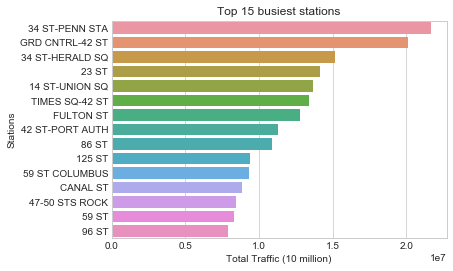

In [21]:
# Verify results: check http://web.mta.info/nyct/facts/ffsubway.htm

sns_plot = sns.barplot(x="Total_Traffic", y='Station_ID', data=station_data)
fig = sns_plot.get_figure()
plt.xlabel("Total Traffic (10 million)")
plt.ylabel("Stations")
plt.title("Top 15 busiest stations")


In [25]:
#Sorting data to find the 'Total_Traffic at each station by 'day of the week'. 

station_data_date=data_nyc_turnstile.groupby(['STATION','Day']).sum()
station_data_date.reset_index(inplace=True)

station_data_date.head(3)

,STATION,Day,ENTRIES,EXITS,Entry_diff,Exit_diff,Total_Traffic
0,1 AV,0,252478467391,135259474380,287848.0,314692.0,602540.0
1,1 AV,1,255066163610,136444838964,308181.0,341547.0,649728.0
2,1 AV,2,258556576049,138513599055,307204.0,331466.0,638670.0


**Top Busiest Station:PENN Station**

Text(0,0.5,'Total Traffic')

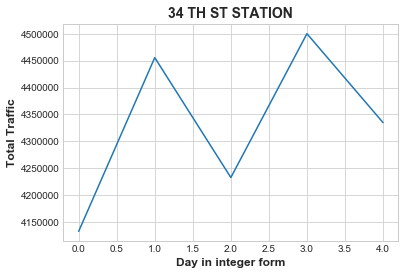

In [30]:
# Graphing activity by day at 34 ST PENN ST (busiest station)

penn_data = station_data_date[station_data_date['STATION'] =='34 ST-PENN STA'] 

penn_data.head()
y = penn_data['Total_Traffic']
x = penn_data['Day']

plt.plot(x,y)
plt.title("34 TH ST STATION",fontsize=14,weight='bold')
plt.xlabel('Day in integer form', fontsize=12, weight='bold')
plt.ylabel('Total Traffic', fontsize=12,weight='bold')



**GRD CNTRL-42 Station**

Text(0,0.5,'Total Traffic')

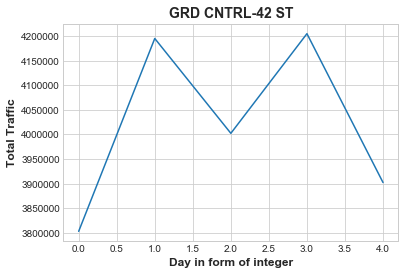

In [31]:
# Graphing activity by day at GRD CNTRL-42 ST 

grand_central_data = station_data_date[station_data_date['STATION'] =='GRD CNTRL-42 ST'] 
y = grand_central_data['Total_Traffic']
x = grand_central_data['Day']

plt.plot(x,y)

plt.title("GRD CNTRL-42 ST",fontsize=14,weight='bold')
plt.xlabel('Day in form of integer', fontsize=12,weight='bold')
plt.ylabel('Total Traffic', fontsize=12,weight='bold')


**34 ST-HERALD SQ Station**

Text(0,0.5,'Total Traffic')

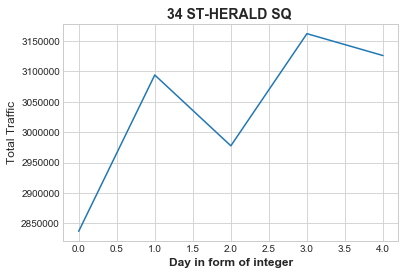

In [32]:
# Graphing activity by day at 34 ST-HERALD SQ 
grand_central_data = station_data_date[station_data_date['STATION'] =='34 ST-HERALD SQ'] 

y = grand_central_data['Total_Traffic']
x = grand_central_data['Day']

plt.plot(x,y)

plt.title("34 ST-HERALD SQ ",fontsize=14,weight='bold')
plt.xlabel('Day in form of integer', fontsize=12,weight='bold')
plt.ylabel('Total Traffic', fontsize=12)
